In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor,Normalize,Compose
from torchvision.datasets import MNIST

#to convert image into tensor
mnist = MNIST(root = 'data',
              download=True,
              train = True,
              transform = Compose([ToTensor(),Normalize(mean = (0.5,),std = (0.5,))]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [3]:
img,label = mnist[0]
print("Label : ",label)
img.shape

Label :  5


torch.Size([1, 28, 28])

In [4]:
#creating batches and dataloader
batch_size = 100
from torch.utils.data import DataLoader
data_loader = DataLoader(mnist,batch_size,shuffle=True)


In [5]:
##################################### for GPU ###########################

def get_default_device():
    # pick the gpu if available
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    #move tensors to choosen device
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)


class DeviceDataLoader():
    # move the batches of the data to our selected device
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

device = get_default_device()

data_loader = DeviceDataLoader(data_loader, device)

#########################################################################

# Discriminator Network

In [6]:
img_size = 784
h_size = 256

In [7]:
import torch.nn as nn
D = nn.Sequential(
    nn.Linear(img_size,h_size),
    nn.LeakyReLU(0.2),
    nn.Linear(h_size,h_size),
    nn.LeakyReLU(0.2),
    nn.Linear(h_size,1),
    nn.Sigmoid()
)
#load discriminator to device
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Generator Network

In [8]:
latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size,h_size),
    nn.ReLU(),
    nn.Linear(h_size,h_size),
    nn.ReLU(),
    nn.Linear(h_size,img_size),
    nn.Tanh()
)


### An example to create random image

In [9]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

In [10]:
y = G(torch.randn(2,latent_size))
gen_imags = denorm(y.reshape((-1,28,28)).detach())

In [11]:
gen_imags.shape

torch.Size([2, 28, 28])

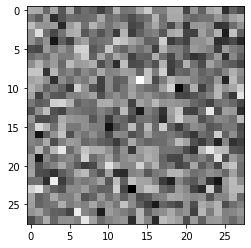

In [12]:
import matplotlib.pyplot as plt
plt.imshow(gen_imags[0],cmap = 'gray')

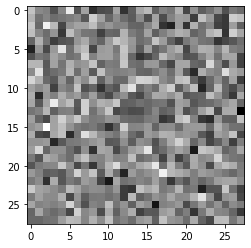

In [13]:
plt.imshow(gen_imags[1],cmap = 'gray')

In [14]:
#MOve the generator to device
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Discriminator Training

In [15]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr = 0.0002)

In [16]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [17]:
def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

## Generator Training

In [18]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training The Model

### To save intermediate images

In [19]:
import os
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

To save batch of real images

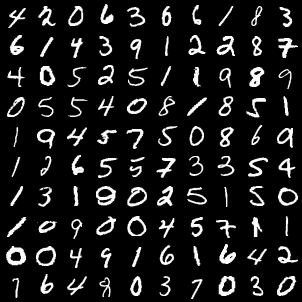

In [20]:
from IPython.display import Image
from torchvision.utils import save_image

for images,_ in data_loader:
    #print(images.shape)
    images = images.reshape(-1,1,28,28)
    save_image(denorm(images),os.path.join(sample_dir,'real_images.png'),nrow = 10)
    break
Image(os.path.join(sample_dir,'real_images.png'))

save the batch of generated (fake) images at the end of every epoch

saving  fake_images-0000.png


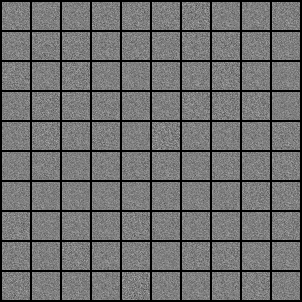

In [21]:
#sample_vectors = torch.randn(batch_size,latent_size).to(device)

def save_fake_images(index):
    sample_vectors = torch.randn(batch_size,latent_size).to(device)
    fake_images = G(sample_vectors)   # return size [128, 784]
    fake_images = fake_images.reshape(-1,1,28,28)
    fake_name = 'fake_images-{0:0=4d}.png'.format(index)
    print('saving ',fake_name)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_name),nrow = 10)

# before training
save_fake_images(0)
Image(os.path.join(sample_dir,'fake_images-0000.png'))

In [22]:
#total Number of batches
len(data_loader)

600

## Training The model

In [23]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.0477, g_loss: 4.5230, D(x): 0.99, D(G(z)): 0.04
Epoch [0/100], Step [400/600], d_loss: 0.3901, g_loss: 4.3946, D(x): 0.91, D(G(z)): 0.20
Epoch [0/100], Step [600/600], d_loss: 0.0352, g_loss: 4.9837, D(x): 0.99, D(G(z)): 0.03
saving  fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.1387, g_loss: 3.4653, D(x): 0.96, D(G(z)): 0.08
Epoch [1/100], Step [400/600], d_loss: 0.1491, g_loss: 4.9256, D(x): 0.96, D(G(z)): 0.09
Epoch [1/100], Step [600/600], d_loss: 0.2873, g_loss: 4.2494, D(x): 0.91, D(G(z)): 0.12
saving  fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 1.8627, g_loss: 2.9921, D(x): 0.62, D(G(z)): 0.60
Epoch [2/100], Step [400/600], d_loss: 0.0819, g_loss: 3.9093, D(x): 0.99, D(G(z)): 0.07
Epoch [2/100], Step [600/600], d_loss: 0.5136, g_loss: 3.1477, D(x): 0.77, D(G(z)): 0.16
saving  fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.4912, g_loss: 2.2733, D(x): 0.88, D(G(z)): 0.25
Epoch [3/100], Step [40

Epoch [27/100], Step [600/600], d_loss: 0.4305, g_loss: 2.9351, D(x): 0.82, D(G(z)): 0.04
saving  fake_images-0028.png
Epoch [28/100], Step [200/600], d_loss: 0.3293, g_loss: 3.2020, D(x): 0.91, D(G(z)): 0.12
Epoch [28/100], Step [400/600], d_loss: 0.3003, g_loss: 3.8952, D(x): 0.91, D(G(z)): 0.09
Epoch [28/100], Step [600/600], d_loss: 0.2598, g_loss: 4.4498, D(x): 0.89, D(G(z)): 0.04
saving  fake_images-0029.png
Epoch [29/100], Step [200/600], d_loss: 0.2968, g_loss: 3.7710, D(x): 0.91, D(G(z)): 0.12
Epoch [29/100], Step [400/600], d_loss: 0.3233, g_loss: 3.7045, D(x): 0.92, D(G(z)): 0.12
Epoch [29/100], Step [600/600], d_loss: 0.3004, g_loss: 3.5564, D(x): 0.88, D(G(z)): 0.05
saving  fake_images-0030.png
Epoch [30/100], Step [200/600], d_loss: 0.4127, g_loss: 3.9049, D(x): 0.86, D(G(z)): 0.11
Epoch [30/100], Step [400/600], d_loss: 0.5451, g_loss: 3.8537, D(x): 0.87, D(G(z)): 0.16
Epoch [30/100], Step [600/600], d_loss: 0.2543, g_loss: 3.2066, D(x): 0.90, D(G(z)): 0.07
saving  fake_

Epoch [55/100], Step [400/600], d_loss: 0.5825, g_loss: 2.6982, D(x): 0.86, D(G(z)): 0.22
Epoch [55/100], Step [600/600], d_loss: 0.4533, g_loss: 2.8402, D(x): 0.91, D(G(z)): 0.21
saving  fake_images-0056.png
Epoch [56/100], Step [200/600], d_loss: 0.5899, g_loss: 1.6476, D(x): 0.84, D(G(z)): 0.26
Epoch [56/100], Step [400/600], d_loss: 0.5881, g_loss: 3.4219, D(x): 0.76, D(G(z)): 0.11
Epoch [56/100], Step [600/600], d_loss: 0.5545, g_loss: 2.1208, D(x): 0.77, D(G(z)): 0.14
saving  fake_images-0057.png
Epoch [57/100], Step [200/600], d_loss: 0.7160, g_loss: 2.1794, D(x): 0.79, D(G(z)): 0.23
Epoch [57/100], Step [400/600], d_loss: 0.5412, g_loss: 2.7620, D(x): 0.81, D(G(z)): 0.16
Epoch [57/100], Step [600/600], d_loss: 0.6080, g_loss: 2.3950, D(x): 0.83, D(G(z)): 0.22
saving  fake_images-0058.png
Epoch [58/100], Step [200/600], d_loss: 0.5759, g_loss: 2.9133, D(x): 0.85, D(G(z)): 0.22
Epoch [58/100], Step [400/600], d_loss: 0.6800, g_loss: 2.0098, D(x): 0.80, D(G(z)): 0.25
Epoch [58/100

Epoch [83/100], Step [200/600], d_loss: 0.7378, g_loss: 2.2774, D(x): 0.76, D(G(z)): 0.22
Epoch [83/100], Step [400/600], d_loss: 0.7433, g_loss: 2.1360, D(x): 0.73, D(G(z)): 0.19
Epoch [83/100], Step [600/600], d_loss: 0.7590, g_loss: 1.7855, D(x): 0.73, D(G(z)): 0.20
saving  fake_images-0084.png
Epoch [84/100], Step [200/600], d_loss: 0.8314, g_loss: 1.9120, D(x): 0.76, D(G(z)): 0.30
Epoch [84/100], Step [400/600], d_loss: 0.8433, g_loss: 1.7962, D(x): 0.81, D(G(z)): 0.33
Epoch [84/100], Step [600/600], d_loss: 0.5901, g_loss: 1.7746, D(x): 0.79, D(G(z)): 0.19
saving  fake_images-0085.png
Epoch [85/100], Step [200/600], d_loss: 0.6016, g_loss: 1.7694, D(x): 0.75, D(G(z)): 0.18
Epoch [85/100], Step [400/600], d_loss: 0.7102, g_loss: 1.3744, D(x): 0.82, D(G(z)): 0.31
Epoch [85/100], Step [600/600], d_loss: 0.6356, g_loss: 2.3091, D(x): 0.74, D(G(z)): 0.17
saving  fake_images-0086.png
Epoch [86/100], Step [200/600], d_loss: 0.8178, g_loss: 2.2860, D(x): 0.74, D(G(z)): 0.25
Epoch [86/100

In [24]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

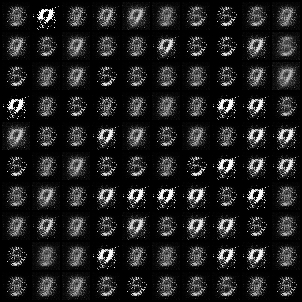

In [25]:
Image('./samples/fake_images-0010.png')

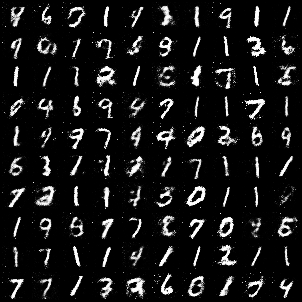

In [27]:
Image('./samples/fake_images-0099.png')

In [28]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

C:\Users\anime\Documents\gans_training.avi

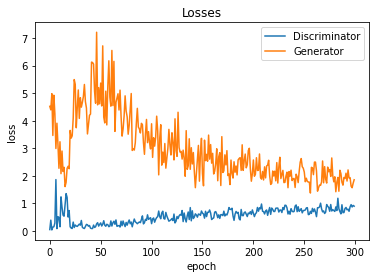

In [29]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

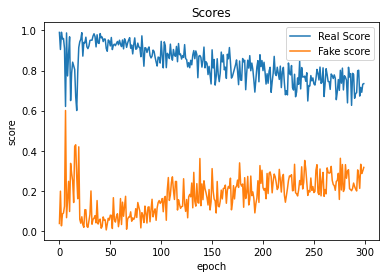

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');